In [1]:
from deepjr.eeg_graph_transformer import EEGGraphTransformer, JRInvDataLoader, create_edge_index
import torch
import torch.nn as nn


In [2]:
path = "./deepjr_training_data"  # Adjust as needed.
estim_params = ('A_e', 'A_i', 'b_e', 'b_i', 'a_1', 'a_2', 'a_3', 'a_4', 'C')
nb_sims = 1000
noise_fact = 1

data_loader = JRInvDataLoader(nb_sims=nb_sims, path=path, estim_params=estim_params, noise_fact=noise_fact)
data_loader.prepare_data()

num_channels = data_loader.X_train.shape[1]
num_timepoints = data_loader.X_train.shape[2]
output_dim = len(estim_params)
edge_index = create_edge_index(num_channels)


In [3]:
model = EEGGraphTransformer(num_channels=num_channels,
                            num_timepoints=num_timepoints,
                            output_dim=output_dim,
                            estim_params=estim_params,
                            embed_dim=64,
                            num_heads=4,
                            graph_embed_dim=32,
                            dropout=0.1)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

# (Use the training loop from the file or your own variant)


In [4]:
epochs = 10
batch_size = 8
num_samples = data_loader.X_train.shape[0]
for epoch in range(epochs):
    model.train()
    permutation = torch.randperm(num_samples)
    epoch_loss = 0.0
    for i in range(0, num_samples, batch_size):
        indices = permutation[i:i+batch_size]
        x_batch = torch.tensor(data_loader.X_train[indices], dtype=torch.float32)
        y_batch = torch.tensor(data_loader.y_train[indices], dtype=torch.float32)
        optimizer.zero_grad()
        # Forward pass: pass both EEG data and edge_index.
        outputs = model(x_batch, edge_index)
        loss = loss_fn(outputs, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    avg_loss = epoch_loss / (num_samples / batch_size)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")



Epoch [1/10], Loss: 0.0437
Epoch [2/10], Loss: 0.0274
Epoch [3/10], Loss: 0.0274
Epoch [4/10], Loss: 0.0272
Epoch [5/10], Loss: 0.0271
Epoch [6/10], Loss: 0.0256
Epoch [7/10], Loss: 0.0247
Epoch [8/10], Loss: 0.0246
Epoch [9/10], Loss: 0.0243
Epoch [10/10], Loss: 0.0245


In [7]:
import torch.nn.functional as F
# --- Evaluation Example ---
model.eval()
X_test_tensor = torch.tensor(data_loader.X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(data_loader.y_test, dtype=torch.float32)
with torch.no_grad():
    predictions = model(X_test_tensor, edge_index)
mse_loss = F.mse_loss(predictions, y_test_tensor)
print(f"Test MSE Loss: {mse_loss.item():.4f}")




Test MSE Loss: 0.0239


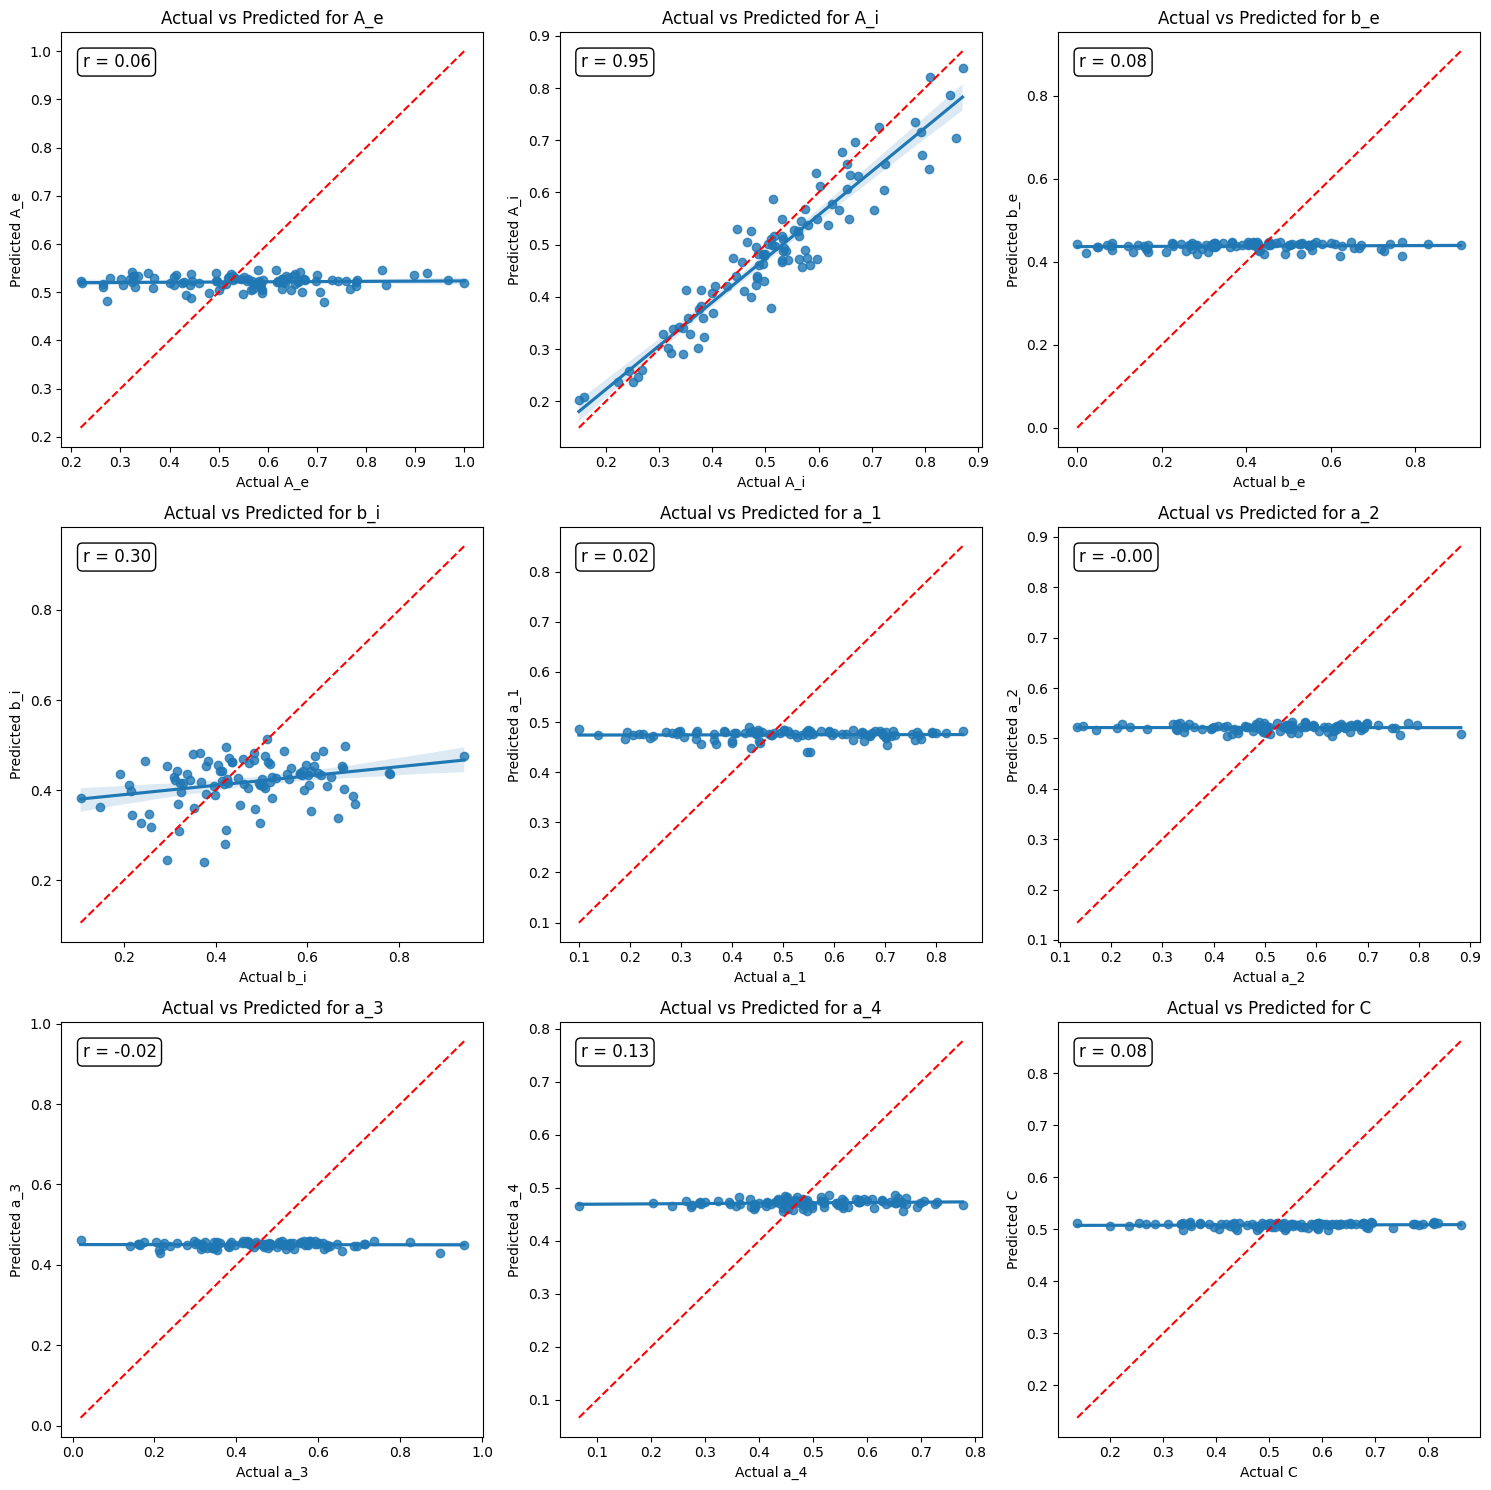

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np

# Convert predictions to numpy arrays if they're tensors.
predictions_np = predictions.numpy()
y_test_np = data_loader.y_test

# Define grid dimensions.
num_params = len(estim_params)
num_cols = 3
num_rows = math.ceil(num_params / num_cols)

# Create subplots.
fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 5, num_rows * 5))
axes = axes.flatten()  # Flatten for easier iteration

for i, param in enumerate(estim_params):
    # Calculate correlation coefficient for the parameter.
    corr = np.corrcoef(y_test_np[:, i], predictions_np[:, i])[0, 1]
    
    # Create the regression plot for the i-th parameter.
    sns.regplot(x=y_test_np[:, i], y=predictions_np[:, i], ax=axes[i])
    axes[i].set_xlabel("Actual " + param)
    axes[i].set_ylabel("Predicted " + param)
    axes[i].set_title(f"Actual vs Predicted for {param}")
    
    # Plot the diagonal line.
    x_min, x_max = y_test_np[:, i].min(), y_test_np[:, i].max()
    axes[i].plot([x_min, x_max], [x_min, x_max], 'r--')
    
    # Annotate correlation coefficient on the plot.
    axes[i].text(0.05, 0.95, f"r = {corr:.2f}", transform=axes[i].transAxes,
                 fontsize=12, verticalalignment='top', bbox=dict(boxstyle="round", fc="w"))

# Hide any unused subplots.
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()
